In [1]:
%%capture
!pip install einops
!pip install tab-transformer-pytorch
!pip install pytorch-tabnet
!pip install hyper-connections
!pip install ipyfilechooser

In [ ]:
import os
import requests
import shutil
import matplotlib.pyplot as plt
from huggingface_hub import snapshot_download
# from google.colab import userdata
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()



repo_id = "your_repo_id"
repo_type = "dataset"  # Specify the repository type (model or dataset)
destination_path = "SMH"
# token = ""  # Replace with your actual Hugging Face token
# token = userdata.get("HF_TOKEN") # Token as a secret on colab
token = user_secrets.get_secret("HF_token") # Token for kaggle

In [ ]:
%%capture

# # DOWNLOAD THE FOLDERS FILE FROM KAGGLE (1st run)
# if not os.path.exists(destination_path):
#     os.makedirs(destination_path)

# # Download the entire dataset to the specified destination path
# snapshot_download(repo_id, repo_type=repo_type, revision="main", token=token, local_dir=destination_path)

# # Move all files and folders in the 'SMH' directory to the current working directory
# for item in os.listdir(destination_path):
#     item_path = os.path.join(destination_path, item)
#     if os.path.isdir(item_path):
#         shutil.move(item_path, os.getcwd())
#         print(f"Moved '{item}' folder to the current working directory.")
#     else:
#         shutil.move(item_path, os.getcwd())
#         print(f"Moved '{item}' file to the current working directory.")

# print("Finished moving files and folders.")


# Bridge Geometry for later plotting

In [ ]:
from utils.truss_geometric import *
from utils.truss_constraints import *
from utils.truss_helpers import *

span = 25
angle = 45
beam_length = 2.5
skip_rod = []
truss_mode = "warren" # warren, pratt, howe

# Calculation of bridge geometry
height, spacing, diag = calculate_bridge(span, angle, beam_length, truss_mode)
n_columns, n_nod_tot, n_rods, n_beams, n_ele_tot, n_bot_beams = calculate_essential_elements(span, spacing, truss_mode, skip_rod)

# Recalculates the skip_rod to match the truss design
skip_rod = truss_design(n_bot_beams, n_rods, truss_mode)
n_columns, n_nod_tot, n_rods, n_beams, n_ele_tot, n_bot_beams = calculate_essential_elements(span, spacing, truss_mode, skip_rod)


# Calculation of nodal coordinates and construction of par, pel matrices and element node indices
# Building priorty: Beams -> Columns -> Rods
nodal_coord, par, pel, ele_nod, n_par_tot = calculate_element_node(span, spacing, height, n_dim, n_par_nod, truss_mode, skip_rod)


# Seperating nodal coordinates into x and y coordinates
X = np.zeros(n_nod_tot, dtype=float)
Y = np.zeros(n_nod_tot, dtype=float)
X[:] = nodal_coord[:, 0]
Y[:] = nodal_coord[:, 1]

# # -------- ELEMENT CHARACTERIZING DATA --------
h = np.zeros(n_ele_tot, dtype=np.float32)
J = np.zeros(n_ele_tot, dtype=np.float32)
A = np.zeros(n_ele_tot, dtype=np.float32)
beta = np.zeros(n_ele_tot,dtype=np.float32)
ro = np.zeros(n_ele_tot,dtype=np.float32)
E = np.zeros(n_ele_tot, dtype=np.float32)


# # -------- ELEMENT PROPERTIES --------
J, A, h, beta, ro, E, G = calculate_element_properties(n_columns, n_beams, diag, spacing, height, J, A, h, beta, ro, E, X, Y, ele_nod, shear_mod,
                                                 width_properties, height_properties, unit_weight_properties, elastic_mod_properties)

# DL Configuration

In [ ]:
import os
import copy
import time
import torch
import random
import importlib
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from collections import deque
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts, OneCycleLR

import tab_transformer_copy
import matplotlib.pyplot as plt
from tab_transformer_copy import TabTransformer_edit
from sklearn.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetRegressor
from tab_transformer_pytorch import TabTransformer, FTTransformer
from helper_analysis import normalize_data, load_and_combine_data, format_array, load_and_normalize_data_tensor, denormalize_data, min_max_scale


folder_path = "/kaggle/working/combinedOutputs" #combinedOutputs or Outputs
epochs_dl = 6000 # For deep learning models
epochs_ml = 200 # For machine learning models
max_files = 1  # Combined datasets are now used (Previously concat 6 = 5 damaged, 8 = 6 damaged)
seed = 42
scaling_type = "minmax"  # "minmax" or any other for z-score
scaling_type2 = "min_max" # "z-score"


# Define the ratio for the train-test split
train_ratio = 0.8

# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Define your L1 regularization strength
l1 = 0.0001
l2 = 1e-5

In [ ]:
#@title Loading the data and normalizing
# Load and normalize the data
file_outputs = "_combo_output1234" # All possible values to choose1234, 12345, 4567, 67
E_tensor, E_return, E_return2 = load_and_normalize_data_tensor(folder_path, f"E{file_outputs}", max_files=max_files, scaling_type=scaling_type2)
A_tensor, _, _ = load_and_normalize_data_tensor(folder_path, f"A{file_outputs}", max_files=max_files, scaling_type=scaling_type2)
J_tensor, _, _ = load_and_normalize_data_tensor(folder_path, f"J{file_outputs}", max_files=max_files, scaling_type=scaling_type2)
h_tensor, h_return, h_return2 = load_and_normalize_data_tensor(folder_path, f"h{file_outputs}", max_files=max_files, scaling_type=scaling_type2)
X_tensor, _, _ = load_and_normalize_data_tensor(folder_path, f"X{file_outputs}", max_files=max_files, scaling_type=scaling_type2)
Y_tensor, _, _ = load_and_normalize_data_tensor(folder_path, f"Y{file_outputs}", max_files=max_files, scaling_type=scaling_type2)
w_tensor, _, _ = load_and_normalize_data_tensor(folder_path, f"w{file_outputs}", max_files=max_files, scaling_type=scaling_type2)
T_tensor, _, _ = load_and_normalize_data_tensor(folder_path, f"T{file_outputs}", max_files=max_files, scaling_type=scaling_type2)

# After loading the data. Make a new data tensor of size (n_samples, n_features) taking A_tensor as reference
# Starting from the 2nd index and moving by 3 beta (the angle) will be 0 and the rest will be 90 degrees (pi/2)
E_tensor.shape, A_tensor.shape, J_tensor.shape, h_tensor.shape, X_tensor.shape, w_tensor.shape

(torch.Size([128764, 39]),
 torch.Size([128764, 39]),
 torch.Size([128764, 39]),
 torch.Size([128764, 39]),
 torch.Size([128764, 156]),
 torch.Size([128764, 156]))

In [ ]:
beta_tensor = torch.zeros(A_tensor.shape)

for i in range(A_tensor.shape[1]):
    if i <= 18:
        beta_tensor[:, i] = 0
    else:
        beta_tensor[:, i] = np.pi/4

beta_tensor, _, _ = min_max_scale(beta_tensor)

In [8]:
# # Take only 60k sample if you train a subset for faster inference
# E_tensor = E_tensor[:60000]
# A_tensor = A_tensor[:60000]
# J_tensor = J_tensor[:60000]
# h_tensor = h_tensor[:60000]
# X_tensor = X_tensor[:60000]
# Y_tensor = Y_tensor[:60000]
# w_tensor = w_tensor[:60000]
# T_tensor = T_tensor[:60000]

# Initialize the data and model

In [ ]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

n_ele = A_tensor.shape[1]
n_ele2 = n_ele*2
n_ele3 = n_ele*3

# Split X_data and w_data into three separate sets of features
X1_tensor = X_tensor[:, :n_ele].clone().detach()
X2_tensor = X_tensor[:, n_ele:n_ele2].clone().detach()
X3_tensor = X_tensor[:, n_ele2:n_ele3].clone().detach()
Y1_tensor = Y_tensor[:, :n_ele].clone().detach()
Y2_tensor = Y_tensor[:, n_ele:n_ele2].clone().detach()
Y3_tensor = Y_tensor[:, n_ele2:n_ele3].clone().detach()
w1_tensor = w_tensor[:, :n_ele].clone().detach()
w2_tensor = w_tensor[:, n_ele:n_ele2].clone().detach()
w3_tensor = w_tensor[:, n_ele2:n_ele3].clone().detach()

# Extra 4th mode due to added complexity
X4_tensor = X_tensor[:, n_ele3:].clone().detach()
Y4_tensor = Y_tensor[:, n_ele3:].clone().detach()
w4_tensor = w_tensor[:, n_ele3:].clone().detach()

# Concatenate all the data to be fed to the model
x_cont = torch.cat((A_tensor, J_tensor, h_tensor, w1_tensor, w2_tensor, w3_tensor, w4_tensor, X1_tensor, 
                    X2_tensor, X3_tensor, X4_tensor, Y1_tensor, Y2_tensor, Y3_tensor, Y4_tensor), dim=1)
# Not used (categorical data)
x_categ = torch.empty((x_cont.shape[0], 0))

# To normalize in the TabTransformer instead
cont_mean_std = torch.randn(x_cont.shape[1], 2)

# Split the data into a training set and a test set and get the indices
x_cont_train, x_cont_test, E_train, E_test, train_indices, test_indices = train_test_split(
    x_cont, E_tensor, range(E_tensor.shape[0]), train_size=train_ratio, random_state=seed
)



# Move the data to the device
x_categ = x_categ.to(device) # This is the only tensor with categorical data
x_cont_train = x_cont_train.to(device)
x_cont_test = x_cont_test.to(device)
E_train = E_train.to(device)
E_test = E_test.to(device)
Y3_tensor.shape

torch.Size([128764, 39])

In [ ]:
# Original
model = TabTransformer_edit(
    categories=(),
    num_continuous=x_cont.shape[1],   # continuous features
    dim=x_cont.shape[1],              # dimension, paper set at 32
    dim_head=16,                      # dimension of each head, paper set at 16
    dim_out=E_tensor.shape[1],        # 15 due to the shape of E_data
    depth=3,                          # depth, paper recommended 6 (9 worked better by .02%)
    heads=15,                         # heads, paper recommends 8
    attn_dropout=0.4,                 # post-attention dropout
    ff_dropout=0.4,                   # feed forward dropout
    mlp_hidden_mults=(4,2),           # relative multiples of each hidden dimension of the last mlp to logits
    mlp_act=nn.ReLU6(),               # activation for final mlp, defaults to relu, but could be anything else (selu, ELU, PReLU, Tanh, Sigmoid)
    mlp_dropout=0.05,
    #mlp_use_residual=True,
    #continuous_mean_std=cont_mean_std # normalize the continuous values before layer norm
)

In [125]:
class BalancedLoss(nn.Module):
    def forward(self, pred, target):
        abs_error = torch.abs(pred - target)
        rel_error = abs_error / (torch.abs(target) + 1e-8)
        return torch.mean(abs_error + rel_error)

class FocalRegressionLoss(nn.Module):
    def __init__(self, alpha=2.0, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, pred, target):
        diff = torch.abs(pred - target)
        loss = self.alpha * torch.pow(diff, self.gamma)
        return loss.mean()
    
class LogCoshLoss(nn.Module):
    def forward(self, pred, target):
        return torch.mean(torch.log(torch.cosh(pred - target)))
    
class QuantileLoss(nn.Module):
    def __init__(self, quantile=0.5):
        super().__init__()
        self.quantile = quantile

    def forward(self, pred, target):
        diff = target - pred
        return torch.mean(torch.max(self.quantile * diff, (self.quantile - 1) * diff)), None

class QuantileLoss_modified(nn.Module):
    def __init__(self, quantile=0.5, threshold_weight=2):
        super().__init__()
        self.quantile = quantile
        self.threshold_weight = threshold_weight
    
    def forward(self, pred, target):
        diff = target - pred
        loss = torch.max(self.quantile * diff, (self.quantile - 1) * diff)
        
        # Calculate element-wise quantile threshold
        ele_quantile = target * self.quantile
        
        # Determine how many diffs are above the quantile threshold
        above_threshold = (diff.abs() > ele_quantile).float()
        
        # Apply additional weight to losses above the threshold
        weighted_loss = loss * torch.min((1 + (self.threshold_weight - 1) * above_threshold), torch.tensor(self.threshold_weight * 4))
        
        return torch.mean(weighted_loss), above_threshold.mean()


class NormalizedCombinedRegressionLoss(nn.Module):
    def __init__(self, alpha=0.3, beta=0.1, gamma=0.1, delta=0.3, zeta=0.2, epsilon=1e-11, start_epoch=20, ramp_epochs=800, quantile=0.1, modify=False):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.delta = delta
        self.zeta = zeta
        self.epsilon = epsilon
        self.start_epoch = start_epoch
        self.ramp_epochs = ramp_epochs
        self.huber_loss = nn.HuberLoss(delta=1.0)
        self.mse_loss = nn.MSELoss()
        self.mae_loss = nn.L1Loss()
        self.logcosh_loss = LogCoshLoss()
        self.quantile_loss = QuantileLoss(quantile=quantile)
        if modify:
            self.quantile_loss = QuantileLoss_modified(quantile=quantile)
        self.current_epoch = 0

    def forward(self, pred, target):
        huber = self.huber_loss(pred, target)
        mse = self.mse_loss(pred, target)
        mae = self.mae_loss(pred, target)
        logcosh = self.logcosh_loss(pred, target)
        quantile, _ = self.quantile_loss(pred, target)
        
        # Normalize losses
        norm_factor = torch.mean(torch.abs(target) + self.epsilon)
        normalized_huber = huber / norm_factor
        normalized_mse = torch.sqrt(mse) / norm_factor
        normalized_mae = mae / norm_factor
        normalized_logcosh = logcosh / norm_factor
        normalized_quantile = quantile / norm_factor

        total_loss = (
            self.alpha * normalized_huber + 
            self.beta * normalized_mse + 
            self.gamma * normalized_mae + 
            self.zeta * normalized_quantile
        )

        # Apply LogCosh loss after start_epoch
        if self.current_epoch >= self.start_epoch:
            ramp_factor = min(1.0, (self.current_epoch - self.start_epoch + 1) / self.ramp_epochs)
            total_loss += ramp_factor * self.delta * normalized_logcosh
        
        return total_loss + self.epsilon

    def update_epoch(self, epoch):
        self.current_epoch = epoch

## Summary of findings

In [ ]:
"""
Original run during optimizing parameters 1->
Results: Test -> Unseen test 
Original: 4.0 -> 8.5% 50 mins 
Original_edit: 4.2 -> 7.8% 90 mins
Original_edit_combined: 2.6 - > 7.1% 120 mins

Original_edit_combined_train: 2.0 -> 6.7% 130 mins 9.1k epoch # 0.7 split
Original_edit_combined_train_elepunish: 1.8 -> 6.1% 110 mins 8.3k epoch # 0.7 split and new loss function
"""


"""
Dataset 1->4 damaged full data ~= 130k combinations
run 1 original loss function: 4.74% MAPE and 2.52% MDAPE
run 2 combined loss function: 2.436% Mape and 1.25% MDAPE
run 3 combined loss function optimized: 1.94% Mape and 1.067% MDAPE
"""

Epoch 0, Train Loss: 0.4633, Val Loss: 0.4365
Learning rate: 0.000100
Epoch 10, Train Loss: 0.1496, Val Loss: 0.3321
Learning rate: 0.000100
Epoch 20, Train Loss: 0.0446, Val Loss: 0.1951
Learning rate: 0.000100
Epoch 30, Train Loss: 0.0374, Val Loss: 0.1298
Learning rate: 0.000100
Epoch 40, Train Loss: 0.0297, Val Loss: 0.1101
Learning rate: 0.000100
Epoch 50, Train Loss: 0.0267, Val Loss: 0.1116
Learning rate: 0.000100
Epoch 60, Train Loss: 0.0245, Val Loss: 0.0938
Learning rate: 0.000100
Epoch 70, Train Loss: 0.0227, Val Loss: 0.0704
Learning rate: 0.000100
Epoch 80, Train Loss: 0.0210, Val Loss: 0.0507
Learning rate: 0.000100
Epoch 90, Train Loss: 0.0197, Val Loss: 0.0379
Learning rate: 0.000100
Epoch 100, Train Loss: 0.0186, Val Loss: 0.0310
Learning rate: 0.000100
Epoch 110, Train Loss: 0.0176, Val Loss: 0.0265
Learning rate: 0.000100
Epoch 120, Train Loss: 0.0167, Val Loss: 0.0236
Learning rate: 0.000100
Epoch 130, Train Loss: 0.0159, Val Loss: 0.0221
Learning rate: 0.000100
Epo

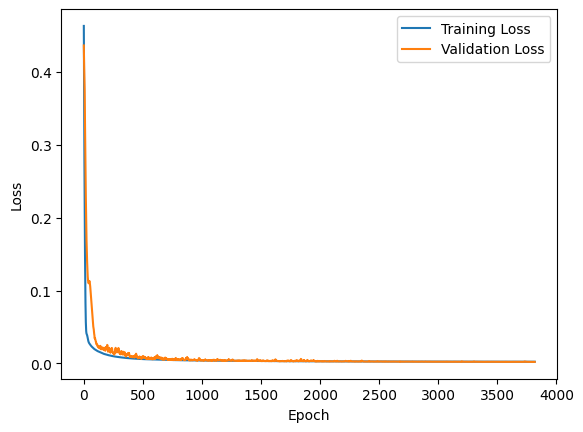

Difference:
[-16355736.0000, -2977072.0000, -6925576.0000, -3878560.0000, 8363264.0000, 12721920.0000, 6293440.0000, -29665776.0000, 12300560.0000, -1036976.0000,
 6578656.0000, 2308880.0000, 2132848.0000, 999696.0000, 13712704.0000, 1207616.0000, -768544.0000, 4277024.0000, -40155776.0000, 9666048.0000,
 1076496.0000, 1349968.0000, -1728992.0000, 5372640.0000, 2814016.0000, 1158224.0000, 4750384.0000, -3361312.0000, -12291776.0000, -9219648.0000,
 -5092480.0000, -1362176.0000, 7677856.0000, 526416.0000, 2793072.0000, 758080.0000, 2381328.0000, 594240.0000, 6504400.0000]

E_test_denorm:
[52500000.0000, 210000000.0000, 105000000.0000, 210000000.0000, 210000000.0000, 210000000.0000, 210000000.0000, 105000000.0000, 210000000.0000, 210000000.0000,
 210000000.0000, 210000000.0000, 210000000.0000, 210000000.0000, 210000000.0000, 210000000.0000, 210000000.0000, 210000000.0000, 105000000.0000, 210000000.0000,
 210000000.0000, 210000000.0000, 210000000.0000, 210000000.0000, 210000000.0000, 2100

In [ ]:
seed=42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
# Define loss function, optimizer, and scheduler
scheduler = 1
# loss_fn = nn.MSELoss()
# loss_fn = nn.PoissonNLLLoss(log_input=True, full=True,)
loss_fn = nn.HuberLoss(delta=1.0)
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01) # 12.98 solo 1.5k runs

# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-5) # 15% with steplr30

if scheduler:
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=20, factor=0.98)


# Move the model to the device
model = model.to(device)
E_test = E_test.to(device)

# Initialize variables for tracking
best_model = None
best_val_loss = float('inf')
best_epoch = 0
epochs_without_improvement = 0
patience = 250  # for early stopping

# For plotting
train_losses = []
val_losses = []

try:
    start_time = time.time()
    for epoch in range(epochs_dl):
        # Training
        model.train()
        pred_train = model(x_categ[:x_cont_train.shape[0]], x_cont_train)
        loss = loss_fn(pred_train, E_train)
        
        optimizer.zero_grad()
        loss.backward()
    
        # Gradient clipping
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Validation
        model.eval()
        with torch.no_grad():
            pred_val = model(x_categ[:x_cont_test.shape[0]], x_cont_test)
            val_loss = loss_fn(pred_val, E_test)
        
        # Update scheduler
        if scheduler:
            scheduler.step(val_loss)
        
        # Check if validation loss has improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            best_model = copy.deepcopy(model.state_dict())
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
        
        # Early stopping
        if epochs_without_improvement >= patience:
            print(f'Early stopping at epoch {epoch} due to no improvement in validation loss.')
            break
        
        # Store losses for plotting
        train_losses.append(loss.item())
        val_losses.append(val_loss.item())
        
        # Print progress
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')
            print(f'Learning rate: {optimizer.param_groups[0]["lr"]:.6f}')
except KeyboardInterrupt:
    print("Training interrupted by user.")

finally:
    print(f"Time taken: {time.time() - start_time}")
    print(f'Best epoch: {best_epoch}, Best validation loss: {best_val_loss:.4f}')
    
    # Load the best model
    model.load_state_dict(best_model)
    
    # Plot the loss values of the training set and the validation set
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Test the model
    model.eval()
    with torch.no_grad():
        pred_test = model(x_categ[:x_cont_test.shape[0]], x_cont_test)
    
    # Move the predictions back to the CPU for further processing
    pred_test = pred_test.to("cpu")
    E_test = E_test.to("cpu")
    # Denormalize the E_tensor
    E_test_denorm = denormalize_data(E_test, E_return, E_return2, scaling_type)
    E_test_denorm_np = E_test_denorm.numpy()
    # Denormalize the predictions
    pred_test_denorm = denormalize_data(pred_test, E_return, E_return2, scaling_type)
    pred_test_denorm_np = pred_test_denorm.numpy()
    
    # MAPE
    mape = np.mean(np.abs((E_test_denorm_np - pred_test_denorm_np) / np.abs(E_test_denorm_np))) * 100
    # MdAPE
    mdape = np.median(np.abs((E_test_denorm_np - pred_test_denorm_np) / np.abs(E_test_denorm_np))) * 100
    
    # Calculate the difference
    difference = E_test_denorm_np - pred_test_denorm_np
    
    
    sample = random.randint(0,len(pred_test_denorm))
    print("Difference:\n" + format_array(difference[sample], 4))
    print("\nE_test_denorm:\n" + format_array(E_test_denorm_np[sample], 4))
    print("\nPred_test_denorm:\n" + format_array(pred_test_denorm_np[sample], 4))
    print(f"\n\nMAPE: {mape.item():.4f}%")
    print(f'MdAPE: {mdape}%')
    print(f'Best epoch: {best_epoch}')

    model_name = 'warren_sp25_run15k_edit_original.pth'
    torch.save(model.state_dict(), model_name)

In [ ]:
class CombinedRegressionLoss(nn.Module):
    def __init__(self, alpha=0.4, beta=0.4, gamma=0.2):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.huber_loss = nn.HuberLoss(delta=1.0)
        self.mse_loss = nn.MSELoss()
        self.mae_loss = nn.L1Loss()

    def forward(self, pred, target):
        huber = self.huber_loss(pred, target)
        mse = self.mse_loss(pred, target)
        mae = self.mae_loss(pred, target)
        return self.alpha * huber + self.beta * mse + self.gamma * mae

class NormalizedCombinedRegressionLoss_original(nn.Module):
    def __init__(self, alpha=0.4, beta=0.4, gamma=0.2):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.huber_loss = nn.HuberLoss(delta=1.0)
        self.mse_loss = nn.MSELoss()
        self.mae_loss = nn.L1Loss()

    def forward(self, pred, target):
        huber = self.huber_loss(pred, target)
        mse = self.mse_loss(pred, target)
        mae = self.mae_loss(pred, target)

        # Scale losses based on their theoretical properties
        # Huber loss is already balanced, so we keep it as is
        # MSE is quadratic, so we take its square root to make it comparable
        # MAE is linear, so we keep it as is
        scaled_mse = torch.sqrt(mse)

        return self.alpha * huber + self.beta * scaled_mse + self.gamma * mae


# Set the seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Define combined loss function, optimizer and scheduler
loss_fn = NormalizedCombinedRegressionLoss_original(alpha=0.4, beta=0.4, gamma=0.2)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=20, factor=0.98)

# Move the model to the device
model = model.to(device)
E_test = E_test.to(device)

# Initialize variables for tracking
best_model = None
best_val_loss = float('inf')
best_epoch = 0
epochs_without_improvement = 0
patience = 250  # for early stopping

# For plotting
train_losses = []
val_losses = []

try:
    start_time = time.time()
    for epoch in range(epochs_dl):
        # Training
        model.train()
        optimizer.zero_grad()
        
        pred_train = model(x_categ[:x_cont_train.shape[0]], x_cont_train)
        loss = loss_fn(pred_train, E_train)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Validation
        model.eval()
        with torch.no_grad():
            pred_val = model(x_categ[:x_cont_test.shape[0]], x_cont_test)
            val_loss = loss_fn(pred_val, E_test)
        
        # Update scheduler
        scheduler.step(val_loss)
        
        # Check if validation loss has improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            best_model = copy.deepcopy(model.state_dict())
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
        
        # Early stopping
        if epochs_without_improvement >= patience:
            print(f'Early stopping at epoch {epoch} due to no improvement in validation loss.')
            break
        
        # Store losses for plotting
        train_losses.append(loss.item())
        val_losses.append(val_loss.item())
        
        # Clear cache to free memory
        torch.cuda.empty_cache()
        
        # Print progress
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')
            print(f'Learning rate: {optimizer.param_groups[0]["lr"]:.6f}')
except KeyboardInterrupt:
    print("Training interrupted by user.")

finally:
    print(f"Time taken: {time.time() - start_time}")
    print(f'Best epoch: {best_epoch}, Best validation loss: {best_val_loss:.4f}')
    
    # Load the best model
    model.load_state_dict(best_model)
    
    # Plot the loss values of the training set and the validation set
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Test the model
    model.eval()
    with torch.no_grad():
        pred_test = model(x_categ[:x_cont_test.shape[0]], x_cont_test)
    
    # Move the predictions back to the CPU for further processing
    pred_test = pred_test.to("cpu")
    E_test = E_test.to("cpu")
    # Denormalize the E_tensor
    E_test_denorm = denormalize_data(E_test, E_return, E_return2, scaling_type)
    E_test_denorm_np = E_test_denorm.numpy()
    # Denormalize the predictions
    pred_test_denorm = denormalize_data(pred_test, E_return, E_return2, scaling_type)
    pred_test_denorm_np = pred_test_denorm.numpy()
    
    # MAPE
    mape = np.mean(np.abs((E_test_denorm_np - pred_test_denorm_np) / np.abs(E_test_denorm_np))) * 100
    # MdAPE
    mdape = np.median(np.abs((E_test_denorm_np - pred_test_denorm_np) / np.abs(E_test_denorm_np))) * 100
    
    # Calculate the difference
    difference = E_test_denorm_np - pred_test_denorm_np
    
    
    sample = random.randint(0,len(pred_test_denorm))
    print("Difference:\n" + format_array(difference[sample], 4))
    print("\nE_test_denorm:\n" + format_array(E_test_denorm_np[sample], 4))
    print("\nPred_test_denorm:\n" + format_array(pred_test_denorm_np[sample], 4))
    print(f"\n\nMAPE: {mape.item():.4f}%")
    print(f'MdAPE: {mdape}%')
    print(f'Best epoch: {best_epoch}')

    model_name = 'warren_sp25_run15k_edit_combinedregression.pth'
    torch.save(model.state_dict(), model_name)

Epoch 0, Train Loss: 0.8384, Val Loss: 0.7481
Learning rate: 0.000100
Epoch 10, Train Loss: 0.4270, Val Loss: 0.6453
Learning rate: 0.000100
Epoch 20, Train Loss: 0.1837, Val Loss: 0.4496
Learning rate: 0.000100
Epoch 30, Train Loss: 0.1578, Val Loss: 0.3229
Learning rate: 0.000100
Epoch 40, Train Loss: 0.1374, Val Loss: 0.3452
Learning rate: 0.000100
Epoch 50, Train Loss: 0.1284, Val Loss: 0.3696
Learning rate: 0.000100
Epoch 60, Train Loss: 0.1213, Val Loss: 0.3124
Learning rate: 0.000098
Epoch 70, Train Loss: 0.1151, Val Loss: 0.2453
Learning rate: 0.000098
Epoch 80, Train Loss: 0.1100, Val Loss: 0.1881
Learning rate: 0.000098
Epoch 90, Train Loss: 0.1059, Val Loss: 0.1531
Learning rate: 0.000098
Epoch 100, Train Loss: 0.1022, Val Loss: 0.1369
Learning rate: 0.000098
Epoch 110, Train Loss: 0.0989, Val Loss: 0.1227
Learning rate: 0.000098
Epoch 120, Train Loss: 0.0958, Val Loss: 0.1183
Learning rate: 0.000098
Epoch 130, Train Loss: 0.0930, Val Loss: 0.1258
Learning rate: 0.000098
Epo

Epoch 0, Train Loss: 0.8396, Val Loss: 0.7718
Learning rate: 0.000100
Epoch 10, Train Loss: 0.4177, Val Loss: 0.6333
Learning rate: 0.000100
Epoch 20, Train Loss: 0.1739, Val Loss: 0.4252
Learning rate: 0.000100
Epoch 30, Train Loss: 0.1535, Val Loss: 0.3122
Learning rate: 0.000100
Epoch 40, Train Loss: 0.1354, Val Loss: 0.3200
Learning rate: 0.000100
Epoch 50, Train Loss: 0.1268, Val Loss: 0.3481
Learning rate: 0.000099
Epoch 60, Train Loss: 0.1198, Val Loss: 0.2859
Learning rate: 0.000099
Epoch 70, Train Loss: 0.1140, Val Loss: 0.2152
Learning rate: 0.000099
Epoch 80, Train Loss: 0.1094, Val Loss: 0.1699
Learning rate: 0.000099
Epoch 90, Train Loss: 0.1055, Val Loss: 0.1429
Learning rate: 0.000099
Epoch 100, Train Loss: 0.1020, Val Loss: 0.1314
Learning rate: 0.000099
Epoch 110, Train Loss: 0.0988, Val Loss: 0.1238
Learning rate: 0.000099
Epoch 120, Train Loss: 0.0958, Val Loss: 0.1216
Learning rate: 0.000099
Epoch 130, Train Loss: 0.0929, Val Loss: 0.1209
Learning rate: 0.000099
Epo

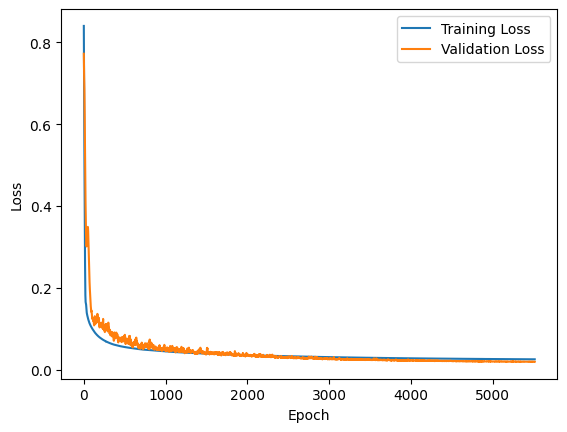

Difference:
[-3094176.0000, -1082880.0000, -391264.0000, 3800224.0000, -32880.0000, -2003492.0000, 4617392.0000, 91136.0000, 5744864.0000, -49973664.0000,
 216720.0000, 4086560.0000, 3167200.0000, 1518336.0000, 1509056.0000, 4392704.0000, 2822064.0000, 165808.0000, 2925008.0000, 186208.0000,
 3937936.0000, 208304.0000, -929472.0000, 1507552.0000, 202064.0000, -3715648.0000, -374864.0000, -4099440.0000, -1513824.0000, 1808016.0000,
 2041024.0000, -2278496.0000, -711424.0000, -271328.0000, -1082016.0000, -2592368.0000, -1698368.0000, -593280.0000, 2101376.0000]

E_test_denorm:
[105000000.0000, 210000000.0000, 210000000.0000, 210000000.0000, 210000000.0000, 52500000.0000, 210000000.0000, 210000000.0000, 210000000.0000, 105000000.0000,
 210000000.0000, 210000000.0000, 210000000.0000, 210000000.0000, 210000000.0000, 210000000.0000, 210000000.0000, 210000000.0000, 210000000.0000, 210000000.0000,
 210000000.0000, 210000000.0000, 210000000.0000, 210000000.0000, 210000000.0000, 210000000.0000, 

In [12]:
class NormalizedCombinedRegressionLoss_original(nn.Module):
    def __init__(self, alpha=0.4, beta=0.4, gamma=0.2):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.huber_loss = nn.HuberLoss(delta=1.0)
        self.mse_loss = nn.MSELoss()
        self.mae_loss = nn.L1Loss()

    def forward(self, pred, target):
        huber = self.huber_loss(pred, target)
        mse = self.mse_loss(pred, target)
        mae = self.mae_loss(pred, target)

        # Scale losses based on their theoretical properties
        # Huber loss is already balanced, so we keep it as is
        # MSE is quadratic, so we take its square root to make it comparable
        # MAE is linear, so we keep it as is
        scaled_mse = torch.sqrt(mse)

        return self.alpha * huber + self.beta * scaled_mse + self.gamma * mae


# Set the seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Define combined loss function, optimizer and scheduler
loss_fn = NormalizedCombinedRegressionLoss_original(alpha=0.4, beta=0.4, gamma=0.2)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=15, factor=0.99)

# Move the model to the device
model = model.to(device)
E_test = E_test.to(device)

# Initialize variables for tracking
best_model = None
best_val_loss = float('inf')
best_epoch = 0
epochs_without_improvement = 0
patience = 250  # for early stopping

# For plotting
train_losses = []
val_losses = []

start_time = time.time()
try:
    for epoch in range(epochs_dl):
        # Training
        model.train()
        optimizer.zero_grad()

        pred_train = model(x_categ[:x_cont_train.shape[0]], x_cont_train)
        loss = loss_fn(pred_train, E_train)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            pred_val = model(x_categ[:x_cont_test.shape[0]], x_cont_test)
            val_loss = loss_fn(pred_val, E_test)

        # Update scheduler
        scheduler.step(val_loss)

        # Check if validation loss has improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            best_model = copy.deepcopy(model.state_dict())
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        # Early stopping
        if epochs_without_improvement >= patience:
            print(f'Early stopping at epoch {epoch} due to no improvement in validation loss.')
            break

        # Store losses for plotting
        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        # Clear cache to free memory
        torch.cuda.empty_cache()

        # Print progress
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')
            print(f'Learning rate: {optimizer.param_groups[0]["lr"]:.6f}')
except KeyboardInterrupt:
    print("Training interrupted by user.")
    
finally:
    print(f"Time taken: {time.time() - start_time}")
    print(f'Best epoch: {best_epoch}, Best validation loss: {best_val_loss:.4f}')
    
    # Load the best model
    model.load_state_dict(best_model)
    
    # Plot the loss values of the training set and the validation set
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Test the model
    model.eval()
    with torch.no_grad():
        pred_test = model(x_categ[:x_cont_test.shape[0]], x_cont_test)
    
    # Move the predictions back to the CPU for further processing
    pred_test = pred_test.to("cpu")
    E_test = E_test.to("cpu")
    # Denormalize the E_tensor
    E_test_denorm = denormalize_data(E_test, E_return, E_return2, scaling_type)
    E_test_denorm_np = E_test_denorm.numpy()
    # Denormalize the predictions
    pred_test_denorm = denormalize_data(pred_test, E_return, E_return2, scaling_type)
    pred_test_denorm_np = pred_test_denorm.numpy()
    
    # MAPE
    mape = np.mean(np.abs((E_test_denorm_np - pred_test_denorm_np) / np.abs(E_test_denorm_np))) * 100
    # MdAPE
    mdape = np.median(np.abs((E_test_denorm_np - pred_test_denorm_np) / np.abs(E_test_denorm_np))) * 100
    
    # Calculate the difference
    difference = E_test_denorm_np - pred_test_denorm_np
    
    
    sample = random.randint(0,len(pred_test_denorm))
    print("Difference:\n" + format_array(difference[sample], 4))
    print("\nE_test_denorm:\n" + format_array(E_test_denorm_np[sample], 4))
    print("\nPred_test_denorm:\n" + format_array(pred_test_denorm_np[sample], 4))
    print(f"\n\nMAPE: {mape.item():.4f}%")
    print(f'MdAPE: {mdape}%')
    print(f'Best epoch: {best_epoch}')

    model_name = 'warren_sp25_run15k_edit_normalizedcombinedregression.pth'
    torch.save(model.state_dict(), model_name)

Epoch 0, Train Loss: 0.6555, Val Loss: 0.5839
Learning rate: 0.000100
Epoch 10, Train Loss: 0.3296, Val Loss: 0.5016
Learning rate: 0.000100
Epoch 20, Train Loss: 0.1414, Val Loss: 0.3512
Learning rate: 0.000100
Epoch 30, Train Loss: 0.1228, Val Loss: 0.2481
Learning rate: 0.000100
Epoch 40, Train Loss: 0.1055, Val Loss: 0.2464
Learning rate: 0.000100
Epoch 50, Train Loss: 0.0988, Val Loss: 0.2744
Learning rate: 0.000100
Epoch 60, Train Loss: 0.0935, Val Loss: 0.2391
Learning rate: 0.000100
Epoch 70, Train Loss: 0.0887, Val Loss: 0.1913
Learning rate: 0.000100
Epoch 80, Train Loss: 0.0848, Val Loss: 0.1461
Learning rate: 0.000100
Epoch 90, Train Loss: 0.0816, Val Loss: 0.1180
Learning rate: 0.000100
Epoch 100, Train Loss: 0.0787, Val Loss: 0.1061
Learning rate: 0.000100
Epoch 110, Train Loss: 0.0762, Val Loss: 0.0929
Learning rate: 0.000100
Epoch 120, Train Loss: 0.0738, Val Loss: 0.0894
Learning rate: 0.000100
Epoch 130, Train Loss: 0.0717, Val Loss: 0.0911
Learning rate: 0.000100
Epo

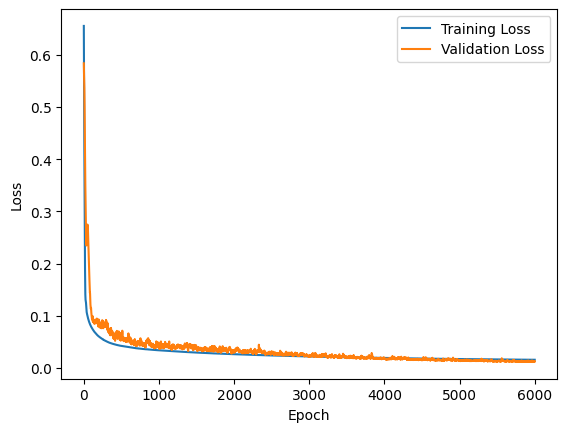

Difference:
[3166868.0000, 4490224.0000, 3585280.0000, 5629552.0000, -929936.0000, -7857680.0000, 1206432.0000, -2317216.0000, 575296.0000, -34388160.0000,
 -4807472.0000, 6119280.0000, 2568176.0000, 520496.0000, 7529184.0000, -3151360.0000, 864832.0000, 1384240.0000, 1711296.0000, 112048.0000,
 1936816.0000, -276976.0000, 636096.0000, -3206512.0000, -3433528.0000, -4694816.0000, 1509008.0000, 1656128.0000, -2504048.0000, -1312384.0000,
 -3252048.0000, -5663232.0000, 2971776.0000, 33472.0000, -1470080.0000, -1566528.0000, 773424.0000, -3335536.0000, -414768.0000]

E_test_denorm:
[52500000.0000, 210000000.0000, 210000000.0000, 210000000.0000, 210000000.0000, 105000000.0000, 210000000.0000, 210000000.0000, 210000000.0000, 105000000.0000,
 210000000.0000, 210000000.0000, 210000000.0000, 210000000.0000, 210000000.0000, 210000000.0000, 210000000.0000, 210000000.0000, 210000000.0000, 210000000.0000,
 210000000.0000, 210000000.0000, 210000000.0000, 210000000.0000, 52500000.0000, 210000000.000

In [17]:
class NormalizedCombinedRegressionLoss_modified(nn.Module):
    def __init__(self, alpha=0.35, beta=0.3, gamma=0.15, delta_max=0.2, threshold=0.1, epsilon=1e-9, start_epoch=10, ramp_epochs=500):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.delta_max = delta_max
        self.threshold = threshold
        self.epsilon = epsilon
        self.start_epoch = start_epoch
        self.ramp_epochs = ramp_epochs
        self.huber_loss = nn.HuberLoss(delta=1.0)
        self.mse_loss = nn.MSELoss()
        self.mae_loss = nn.L1Loss()
        self.current_epoch = 0

    def forward(self, pred, target):
        huber = self.huber_loss(pred, target)
        mse = self.mse_loss(pred, target)
        mae = self.mae_loss(pred, target)
        
        # Scale losses based on their theoretical properties
        scaled_mse = torch.sqrt(mse)
        
        total_loss = self.alpha * huber + self.beta * scaled_mse + self.gamma * mae

        # Only apply high error penalty after start_epoch
        if self.current_epoch >= self.start_epoch:
            # Calculate percentage errors with safeguard against division by zero
            percentage_errors = torch.abs((pred - target) / (target + self.epsilon))
            
            # Clip percentage errors to avoid extremely large values
            percentage_errors = torch.clamp(percentage_errors, max=10)
            
            # Calculate the proportion of errors above the threshold
            above_threshold = (percentage_errors > self.threshold).float()
            proportion_above = torch.mean(above_threshold)
            
            # Dynamically adjust delta based on the proportion of high errors
            delta = self.delta_max * proportion_above
            
            # Apply additional penalty for errors above the threshold
            high_error_penalty = torch.mean(torch.pow(torch.relu(percentage_errors - self.threshold), 2))
            
            # Normalize high_error_penalty to be on a similar scale as other losses
            normalized_high_error_penalty = high_error_penalty / (self.threshold ** 2)
            
            # Gradually introduce the high error penalty over ramp_epochs
            ramp_factor = min(1.0, (self.current_epoch - self.start_epoch + 1) / self.ramp_epochs)
            
            total_loss += ramp_factor * delta * normalized_high_error_penalty
        
        # Add a small epsilon to avoid returning exactly zero
        return total_loss + self.epsilon

    def update_epoch(self, epoch):
        self.current_epoch = epoch


# Set the seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Define combined loss function, optimizer and scheduler
loss_fn = NormalizedCombinedRegressionLoss_modified(alpha=0.35, beta=0.3, gamma=0.15, delta_max=0.2,
                                                    threshold=0.1, epsilon=1e-9, start_epoch=10, ramp_epochs=500)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.005)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=15, factor=0.995)

# Move the model to the device
model = model.to(device)
E_test = E_test.to(device)

# Initialize variables for tracking
best_model = None
best_val_loss = float('inf')
best_epoch = 0
epochs_without_improvement = 0
patience = 350  # for early stopping

# For plotting
train_losses = []
val_losses = []

start_time = time.time()
try:
    for epoch in range(epochs_dl):
        # Training
        model.train()
        optimizer.zero_grad()

        pred_train = model(x_categ[:x_cont_train.shape[0]], x_cont_train)
        loss = loss_fn(pred_train, E_train)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            pred_val = model(x_categ[:x_cont_test.shape[0]], x_cont_test)
            val_loss = loss_fn(pred_val, E_test)

        # Update scheduler
        scheduler.step(val_loss)

        # Check if validation loss has improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            best_model = copy.deepcopy(model.state_dict())
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        # Early stopping
        if epochs_without_improvement >= patience:
            print(f'Early stopping at epoch {epoch} due to no improvement in validation loss.')
            break

        # Store losses for plotting
        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        # Clear cache to free memory
        torch.cuda.empty_cache()

        # Print progress
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')
            print(f'Learning rate: {optimizer.param_groups[0]["lr"]:.6f}')
except KeyboardInterrupt:
    print("Training interrupted by user.")
    
finally:
    print(f"Time taken: {time.time() - start_time}")
    print(f'Best epoch: {best_epoch}, Best validation loss: {best_val_loss:.4f}')
    
    # Load the best model
    model.load_state_dict(best_model)
    
    # Plot the loss values of the training set and the validation set
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Test the model
    model.eval()
    with torch.no_grad():
        pred_test = model(x_categ[:x_cont_test.shape[0]], x_cont_test)
    
    # Move the predictions back to the CPU for further processing
    pred_test = pred_test.to("cpu")
    E_test = E_test.to("cpu")
    # Denormalize the E_tensor
    E_test_denorm = denormalize_data(E_test, E_return, E_return2, scaling_type)
    E_test_denorm_np = E_test_denorm.numpy()
    # Denormalize the predictions
    pred_test_denorm = denormalize_data(pred_test, E_return, E_return2, scaling_type)
    pred_test_denorm_np = pred_test_denorm.numpy()
    
    # MAPE
    mape = np.mean(np.abs((E_test_denorm_np - pred_test_denorm_np) / np.abs(E_test_denorm_np))) * 100
    # MdAPE
    mdape = np.median(np.abs((E_test_denorm_np - pred_test_denorm_np) / np.abs(E_test_denorm_np))) * 100
    
    # Calculate the difference
    difference = E_test_denorm_np - pred_test_denorm_np
    
    
    sample = random.randint(0,len(pred_test_denorm))
    print("Difference:\n" + format_array(difference[sample], 4))
    print("\nE_test_denorm:\n" + format_array(E_test_denorm_np[sample], 4))
    print("\nPred_test_denorm:\n" + format_array(pred_test_denorm_np[sample], 4))
    print(f"\n\nMAPE: {mape.item():.4f}%")
    print(f'MdAPE: {mdape}%')
    print(f'Best epoch: {best_epoch}')

    model_name = 'warren_sp25_run15k_edit_normalizedcombinedregressionmodified.pth'
    torch.save(model.state_dict(), model_name)

# Validation of Model

In [133]:
# 12345 or 4567 or 67
folder_path = "/kaggle/working/Outputs"
file_outputs = "_combo_output5"
E_tensor, E_return, E_return2 = load_and_normalize_data_tensor(folder_path, f"E{file_outputs}", max_files=max_files, scaling_type=scaling_type2)
A_tensor, _, _ = load_and_normalize_data_tensor(folder_path, f"A{file_outputs}", max_files=max_files, scaling_type=scaling_type2)
J_tensor, _, _ = load_and_normalize_data_tensor(folder_path, f"J{file_outputs}", max_files=max_files, scaling_type=scaling_type2)
h_tensor, _, _ = load_and_normalize_data_tensor(folder_path, f"h{file_outputs}", max_files=max_files, scaling_type=scaling_type2)
X_tensor, _, _ = load_and_normalize_data_tensor(folder_path, f"X{file_outputs}", max_files=max_files, scaling_type=scaling_type2)
Y_tensor, _, _ = load_and_normalize_data_tensor(folder_path, f"Y{file_outputs}", max_files=max_files, scaling_type=scaling_type2)
w_tensor, _, _ = load_and_normalize_data_tensor(folder_path, f"w{file_outputs}", max_files=max_files, scaling_type=scaling_type2)
T_tensor, _, _ = load_and_normalize_data_tensor(folder_path, f"T{file_outputs}", max_files=max_files, scaling_type=scaling_type2)

n_ele = A_tensor.shape[1]
n_ele2 = n_ele * 2
n_ele3 = n_ele * 3

# Split X_data and w_data into three separate sets of features
X1_tensor = X_tensor[:, :n_ele].clone().detach()
X2_tensor = X_tensor[:, n_ele:n_ele2].clone().detach()
X3_tensor = X_tensor[:, n_ele2:n_ele3].clone().detach()
Y1_tensor = Y_tensor[:, :n_ele].clone().detach()
Y2_tensor = Y_tensor[:, n_ele:n_ele2].clone().detach()
Y3_tensor = Y_tensor[:, n_ele2:n_ele3].clone().detach()
w1_tensor = w_tensor[:, :n_ele].clone().detach()
w2_tensor = w_tensor[:, n_ele:n_ele2].clone().detach()
w3_tensor = w_tensor[:, n_ele2:n_ele3].clone().detach()

# Extra 4th set
X4_tensor = X_tensor[:, n_ele3:].clone().detach()
Y4_tensor = Y_tensor[:, n_ele3:].clone().detach()
w4_tensor = w_tensor[:, n_ele3:].clone().detach()

# Concatenate continuous features
x_cont = torch.cat((A_tensor, J_tensor, h_tensor, w1_tensor, w2_tensor, w3_tensor, w4_tensor, 
                    X1_tensor, X2_tensor, X3_tensor, X4_tensor, Y1_tensor, Y2_tensor, Y3_tensor, Y4_tensor), dim=1)
# There are no categorical features
x_categ = torch.empty((x_cont.shape[0], 0))

In [131]:
# MODEL
model_test = TabTransformer_edit(
    categories=(),
    num_continuous=x_cont.shape[1],  # continuous features
    dim=x_cont.shape[1],             # dimension, paper set at 32
    dim_head=16,                     # dimension of each head, paper set at 16
    dim_out=E_tensor.shape[1],       # 15 due to the shape of E_data
    depth=3,                         # depth, paper recommended 6 (9 worked better by .02%)
    heads=15,                        # heads, paper recommends 8
    attn_dropout=0.4,                # post-attention dropout
    ff_dropout=0.4,                  # feed forward dropout
    mlp_hidden_mults=(4,2),          # relative multiples of each hidden dimension of the last mlp to logits
    mlp_act=nn.ReLU6(),              # activation for final mlp
    mlp_dropout=0.05,
)

# best_model_curr = 'warren_sp25_run15k_edit_original.pth'
# best_model_curr = 'warren_sp25_run15k_edit_combinedregression.pth'
# best_model_curr = 'warren_sp25_run15k_edit_normalizedcombinedregression.pth'
# best_model_curr = 'warren_sp25_run15k_edit_normalizedcombinedregressionmodified.pth'
best_model_curr = 'warren_sp25_run15k_1234_edit_normalizedcombinedregressionmodified.pth'
state_dict = torch.load(best_model_curr, weights_only=True)
model_test.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
# Test the model
if not 'state_dict' in locals() or not 'model_test' in locals() or not state_dict:
    model_test = model
model_test.eval()

# Move all the data to the device
x_categ = x_categ.to(device)   # Categorical data tensor (empty here)
x_cont = x_cont.to(device)
E_tensor = E_tensor.to(device)
model_test = model_test.to(device)

# Test the model on all data
with torch.no_grad():
    pred_all = model_test(x_categ, x_cont)

# Move predictions back to the CPU for further processing
pred_all = pred_all.to("cpu")
E_all = E_tensor.to("cpu")

# Denormalize the E_tensor
E_all_denorm = denormalize_data(E_all, E_return, E_return2, scaling_type)
E_all_denorm_np = E_all_denorm.numpy()

# Denormalize the predictions
pred_all_denorm = denormalize_data(pred_all, E_return, E_return2, scaling_type)
pred_all_denorm_np = pred_all_denorm.numpy()

# Calculate error metrics (MAPE and MdAPE)
mape = np.mean(np.abs((E_all_denorm_np - pred_all_denorm_np) / np.abs(E_all_denorm_np))) * 100
mdape = np.median(np.abs((E_all_denorm_np - pred_all_denorm_np) / np.abs(E_all_denorm_np))) * 100

# Calculate the difference between the predictions and the ground truth for each sample/element
difference = E_all_denorm_np - pred_all_denorm_np

# For demonstration, select a specific sample to inspect in detail
sample = 123
print("Difference (sample index {}):\n{}".format(sample, format_array(difference[sample], 4)))
print("\nE_all_denorm (sample index {}):\n{}".format(sample, format_array(E_all_denorm_np[sample], 4)))
print("\nPred_all_denorm (sample index {}):\n{}".format(sample, format_array(pred_all_denorm_np[sample], 4)))
print(f"\n\nMAPE: {mape.item():.4f}%")
print(f"MdAPE: {mdape}%")

# -------------------------------
# Compute element-wise minimum and maximum error percentages

# Compute the relative error (in percentage) for all samples and all elements
relative_error = np.abs((E_all_denorm_np - pred_all_denorm_np) / np.abs(E_all_denorm_np)) * 100

# For each element (i.e. for each column), compute the minimum and maximum error percentage across all samples
min_error = np.min(relative_error, axis=0)
max_error = np.max(relative_error, axis=0)

print("\nElement-wise minimum error percentages:")
print(format_array(min_error, 4))

print("\nElement-wise maximum error percentages:")
print(format_array(max_error, 4))

# -------------------------------
# Compute the overall error for each sample by averaging the element-wise relative errors
overall_error = np.mean(relative_error, axis=1)

# Find the sample index with the lowest overall error
best_sample = np.argmin(overall_error)
best_sample_error = overall_error[best_sample]

print(f"\nSample with the overall lowest average error: {best_sample}")
print(f"Average relative error for sample {best_sample}: {best_sample_error:.4f}%")

# # Optionally, print detailed information for the best sample
# print("\nDetailed information for the best sample:")
# print("Difference:\n" + format_array(difference[best_sample], 4))
# print("\nE_all_denorm:\n" + format_array(E_all_denorm_np[best_sample], 4))
# print("\nPred_all_denorm:\n" + format_array(pred_all_denorm_np[best_sample], 4))


Difference (sample index 123):
[-7247936.0000, 7063648.0000, -5517392.0000, -3187296.0000, -6542144.0000, -5402432.0000, -23809568.0000, -7343616.0000, -6717584.0000, -489968.0000,
 31625360.0000, -8648736.0000, -8266704.0000, -7353440.0000, 172624.0000, -3316096.0000, -66608.0000, 6261312.0000, 9081040.0000, -14852424.0000,
 -12877712.0000, -1454832.0000, -1009968.0000, 9637984.0000, -1950960.0000, 5732528.0000, -179360.0000, -1463936.0000, 19029152.0000, -12946968.0000,
 15173664.0000, -2927392.0000, 8761904.0000, 1229952.0000, -662960.0000, 22476384.0000, -1349904.0000, 1647152.0000, -6178464.0000]

E_all_denorm (sample index 123):
[105000000.0000, 210000000.0000, 210000000.0000, 210000000.0000, 210000000.0000, 210000000.0000, 105000000.0000, 210000000.0000, 210000000.0000, 210000000.0000,
 210000000.0000, 210000000.0000, 210000000.0000, 210000000.0000, 210000000.0000, 210000000.0000, 210000000.0000, 210000000.0000, 210000000.0000, 52500000.0000,
 210000000.0000, 210000000.0000, 210

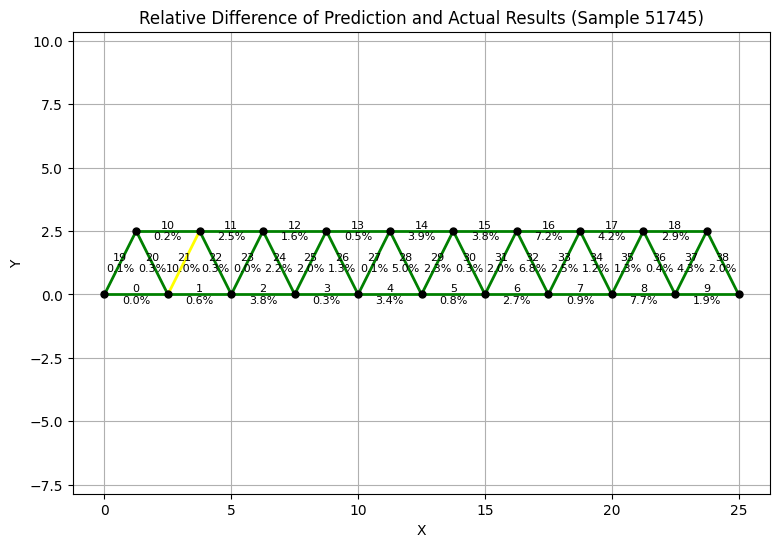

In [55]:
# Define thresholds for different colors
threshold_yellow = 0.1  # 10%
threshold_red = 0.3     # 30%

# Calculate the difference for all samples using the updated variable names
difference = E_all_denorm_np - pred_all_denorm_np

# Define a sample index to demonstrate the color change (ensuring a valid index)
sample = 51745
# sample = random.randint(0, len(difference) - 1)

# Plot each element using its angle beta
plt.figure(figsize=(9, 6))
for i in range(len(ele_nod)):
    x1, y1 = X[ele_nod[i, 0]], Y[ele_nod[i, 0]]  # Start node
    length = h[i]
    # Calculate end point based on length and angle beta
    x2 = x1 + length * np.cos(beta[i])
    y2 = y1 + length * np.sin(beta[i])
    
    # Determine color based on the relative difference
    relative_diff = np.abs(difference[sample, i] / E_all_denorm_np[sample, i])
    if relative_diff >= threshold_red:
        color = 'red'    # Red for significant difference (>= 30%)
    elif relative_diff >= threshold_yellow:
        color = 'yellow' # Yellow for moderate difference (10% - 30%)
    else:
        color = 'green'  # Green for small difference (< 10%)
    
    plt.plot([x1, x2], [y1, y2], color=color, linewidth=2)
    plt.text((x1 + x2) / 2, (y1 + y2) / 2, f"{i}\n{relative_diff:.1%}", 
             ha='center', va='center', fontsize=8)

plt.plot(X, Y, 'ko', markersize=5)  # Plot nodes
plt.axis('equal')
plt.title(f'Relative Difference of Prediction and Actual Results (Sample {sample})')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()
